#  Toy distributions of the $\chi^2$ test statistic in the Poisson regime

We often assume that uncertainties are Gaussian distributed. This is reflected in our use of the $\chi^2$ as a test statistic, which is expected to be distributed according to a $\chi^2$ distribution when we have sufficient events such that the Poisson probability density function can eb approximated as a Gaussian. This notebook uses studies the question:
- how do we expect the $\chi^2$ test statistic to be distributed when the Gaussian approximation does not hold?

To do this, we will create a toy model. We will create psuedo-datasets (a.k.a. "toys") around this model according to the Poisson probability density function, allowing for additional Gaussian shifts due to systematic uncertainties. In each of these toys, we will calculate the $\chi^2$ compared with the true model. We will then plot the distribution of toy $\chi^2$, and see how it compares with the $\chi^2$ function.

### Step 1. Set up

First we need to set the constants which will be used to set up the study. We can
- vary the number of toys we want to study (more = better, as we can perform a more precise comparison!)
- vary the number of bins of our toy model
- vary the expected numbers of SM and BSM events, to take us in/out of the Poisson regime
- vary the degree of Gaussian systematic uncertainty we want to include
- determine what values of $\mu$ we want to evaluate and plot the $\chi^2$ at

Note that $\mu$ is the parameter which will vary the degree of BSM physics in our toy model. This will act as our parameter of interest.

In [1]:
#  Configurable constants!

num_toys = 50000

num_bins = 3

num_expected_SM_events         = 10.
num_expected_BSM_events_per_mu = 2.

frac_syst_err = [0.20, 0.05, -0.10]

plot_toys_at_mu_values = [-10, -5, -2, 0, 2, 5, 10]

### Step 2. Define toy throwing methods

Here we define the methods for throwing toys, using either Gaussian or Poisson probability densities.

Toys thrown using a Gaussian probability density will result in a $\chi^2$-distributed $\chi^2$ test statistic, by construction. This method shows how to throw toys which respect bin-to-bin correlations by diagonalising the covariance matrix.

Toys thrown using a Poisson probability density are more correct when the expected event yield is low. How does this affect the expected distribution of the $\chi^2$ test statistic? That is what we want to study!

In [2]:
#  Required imports

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [3]:
#  Define some functions which allow us to generate toys using either Gaussian or Poisson probability densities

def throw_toys_gaussian (num_toys, expected_values, covariance) :
    eigenvals, error_directions = np.linalg.eig(covariance)
    error_amplitudes = np.sqrt(eigenvals)
    toy_shifts = np.random.normal(0, 1, (num_toys, len(error_amplitudes)))
    toys = []
    for i in range(num_toys) :
        toys.append(np.matmul(error_directions, np.multiply(error_amplitudes, toy_shifts[i])) + expected_values)
    return toys

def throw_toys_poisson (num_toys, expected_values, syst_error_amplitudes) :
    toy_frac_syst_shifts = np.random.normal(0, 1, num_toys)
    stat_shifted_toys    = [np.random.poisson(expected_values[i], num_toys) for i in range(len(expected_values))]
    stat_shifted_toys    = np.array(stat_shifted_toys).transpose()
    toys = []
    for i in range(num_toys) :
        toys.append(stat_shifted_toys[i] + toy_frac_syst_shifts[i]*syst_error_amplitudes)
    return toys

### Step 3: Define $\chi^2$ evaluation methods

Here we define methods which
- construct a stat covariance matrix, given a correlation matrix and assuming Poisson variances 
- construct a syst covariance matrix, given a vector of 100% correlated systematic variations
- calculate the $\chi^2$, given a measured dataset, a prediction, and the (inverse) covariance matrix

In [4]:
#  Define functions for constructing covariance matrices, and evaluating the chi2 test statistic for a given dataset

def get_expected_stat_covariance (expected_correlation_matrix, yields) :
    if type(yields) != np.ndarray :
        yields = get_model_prediction (yields)
    poisson_sqrt_variances = np.sqrt(yields)
    cov = np.zeros(shape=(num_bins, num_bins))
    for i in range(num_bins) :
        for j in range(num_bins) :
            cov[i, j] = expected_correlation_matrix[i, j] * poisson_sqrt_variances[i] * poisson_sqrt_variances[j]
    return cov

def get_syst_covariance_from_NP_variation (yields, absolute_errors) :
    if type(yields) != np.ndarray :
        yields = get_model_prediction (yields)
    if type(absolute_errors) == list :
        absolute_errors = np.array(absolute_errors)
    if type(absolute_errors) != np.ndarray :
        absolute_errors = np.full(shape=yields.shape, fill_value=absolute_errors)
    cov = np.zeros(shape=(num_bins, num_bins))
    for i in range(num_bins) :
        for j in range(num_bins) :
            cov[i, j] = absolute_errors[i] * absolute_errors[j]
    return cov

def get_chi2 (measurement, expectation, cov_inv) :
    residual = measurement - expectation
    return np.matmul(residual, np.matmul(cov_inv, residual))

### Step 4: Construct the toy model

We will now define some arbitrarily chosen values to represent our toy model.

In [5]:
#  Construct a toy model
#    - domain of x is [100, 160]
#    - expected events is configurable

differential_binning = np.linspace(100, 160, num_bins+1)

#    -  SM model is pdf(x) ~ x^-4
#        - integral is (-1/3) * N * (x ** -3)

def toy_model_SM_bin_prob (bin_lower, bin_upper, norm_constant=1.) :
    return (1./3.) * norm_constant * (np.power(bin_upper, -3) - np.power(bin_lower, -3))

norm_constant_SM = 1. / toy_model_SM_bin_prob (differential_binning[0], differential_binning[-1])
toy_model_PDF_SM = toy_model_SM_bin_prob (differential_binning[:-1], differential_binning[1:], num_expected_SM_events        *norm_constant_SM )

#    -  BSM model is pdf(x) ~ gauss(145, 5)
#        - integral is N * erf(145, 5)

def toy_model_BSM_bin_prob (bin_lower, bin_upper, norm_constant=1.) :
    return norm_constant * (stats.norm.cdf(bin_upper, 145., 5.) - stats.norm.cdf(bin_lower, 125., 3.))

norm_constant_BSM        = 1. / toy_model_BSM_bin_prob(differential_binning[0], differential_binning[-1])
toy_model_PDF_BSM_per_mu = toy_model_BSM_bin_prob(differential_binning[:-1], differential_binning[1:], num_expected_BSM_events_per_mu*norm_constant_BSM)

#    -  toy model is SM + |mu|*BSM

def get_model_prediction (mu) :
    return toy_model_PDF_SM + np.fabs(mu) * toy_model_PDF_BSM_per_mu

#  Define some expectation for the stat correlation matrix 
#     - for Poisson variations, stat correlations are complicated, so we will not use them
#     - this is justified because event counting experiments cannot be statistically correlated between bins
#       (if we unfolded the data, we could have stat correlations, but would also have Gaussian uncertainties)

expected_correlation_matrix = np.eye(num_bins)

### Step 5:  plot our toy model at several different values of $\mu$

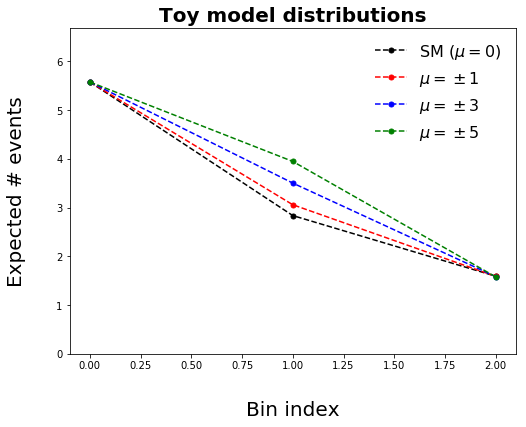

In [6]:
x = np.arange(len(differential_binning)-1)
y_SM = get_model_prediction(0.)
y_m1 = get_model_prediction(1.)
y_m3 = get_model_prediction(3.)
y_m5 = get_model_prediction(5.)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Toy model distributions", weight="bold", fontsize=20)
ax.plot(x, y_SM, "o--", markersize=5, color="k", label=r"SM ($\mu=0$)")
ax.plot(x, y_m1, "o--", markersize=5, color="r", label=r"$\mu=\pm1$")
ax.plot(x, y_m3, "o--", markersize=5, color="b", label=r"$\mu=\pm3$")
ax.plot(x, y_m5, "o--", markersize=5, color="g", label=r"$\mu=\pm5$")
ax.legend(loc="upper right", frameon=False, fontsize=16)
ax.set_ylabel("Expected # events", fontsize=20, labelpad=30)
ax.set_xlabel("Bin index", fontsize=20, labelpad=30)
ax.set_ylim([0, 1.2*np.max(y_m5)])
plt.savefig("toy_model_distributions.pdf", bbox_inches="tight")
plt.show()

### Step 6:  Throw toys, and plot the resulting $\chi^2$ distributions

In [7]:
def get_chi2_from_toys (mu) :
    expected_yields = get_model_prediction (mu)
    
    cov_stat = get_expected_stat_covariance (expected_correlation_matrix, expected_yields)
    syst_err = np.array(frac_syst_err) * expected_yields
    cov_syst = get_syst_covariance_from_NP_variation (expected_yields, syst_err)
    cov      = cov_stat + cov_syst
    cov_inv  = np.linalg.inv(cov)
    
    #toys = throw_toys_gaussian (num_toys, expected_yields, cov)
    toys = throw_toys_poisson (num_toys, expected_yields, syst_err)
    
    to_ret = []
    for toy_idx, toy in enumerate(toys) :
        toy_chi2 = get_chi2(toy, expected_yields, cov_inv)
        to_ret.append(toy_chi2)
    
    return to_ret

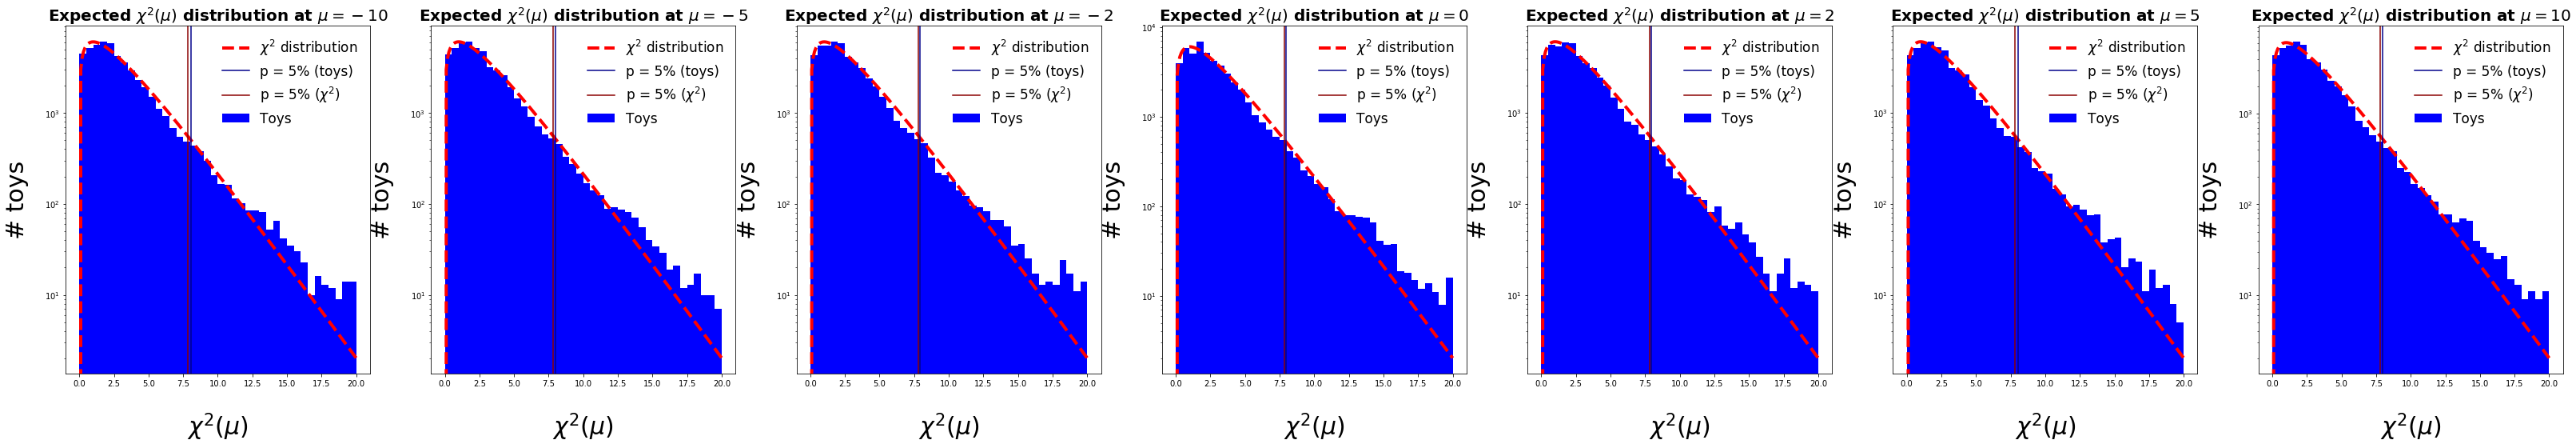

In [8]:
num_plots = len(plot_toys_at_mu_values)
fig = plt.figure(figsize=(8*num_plots, 8))
for plot_idx, mu in enumerate(plot_toys_at_mu_values) :
    vals = get_chi2_from_toys (mu)
    vals.sort()
    ax = fig.add_subplot(1, num_plots, 1+plot_idx)
    ax.hist(vals, bins=np.linspace(0, 20, 41), color="blue", label="Toys")
    x = np.linspace(0, 20, 201)
    ax.plot(x, num_toys*stats.chi2.pdf(x, num_bins)*0.5, "--", label=r"$\chi^2$ distribution", color="r", linewidth=4)
    ax.axvline(vals[int(0.95*len(vals))], color="darkblue", label="p = 5% (toys)")
    ax.axvline(7.815, color="darkred", label=r"p = 5% ($\chi^2$)")
    ax.set_yscale("log")
    ax.legend(loc="upper right", fontsize=17, frameon=False)
    ax.set_title(f"Expected $\chi^2(\mu)$ distribution at $\mu={mu}$", fontsize=20, weight="bold")
    ax.set_ylabel("# toys", fontsize=30, labelpad=20)
    ax.set_xlabel("$\chi^2(\mu)$", fontsize=30, labelpad=30)
plt.savefig("toy_chi2_distributions.pdf", bbox_inches="tight")
plt.show()